In [1]:
import sys,os,re

root = 'C:/QHA/new/QHA2/combined'

filelist = [val for sublist in [[os.path.join(i[0], j) for j in i[2] if j.endswith('.xlsx')] for i in os.walk(root)] for val in sublist]
qpointslist = [val for sublist in [[os.path.join(i[0], j) for j in i[2] if j.endswith('qpoints.yaml')] for i in os.walk(root)] for val in sublist]

regex = re.compile(".*nopa.*")
qpointslist = list(filter(regex.match, qpointslist))


e_v = 'C:\\QHA\\new\\QHA2\\combined\\nopa\\e-v.dat'

v_t = 'C:\\QHA\\new\\QHA2\\combined\\nopa\\volume-temperature.dat'




In [2]:
# import modules
from openpyxl import load_workbook
import pandas as pd
import re

# all possible sheets
sheets = ['Main','Scenarios','Powder Molar Absorption','Powder Absorption','Powder Real Permittivity','Powder Imaginary Permittivity', 'Powder ATR Reflectance', 'Analysis','Crystal R_p','Crystal R_s','Crystal T_p','Crystal T_s','Real Crystal Permittivity','Imag Crystal Permittivity']
powder = [2,3,4,5,6]
crystal = [8,9,10,11,12,13] 

# initilise variables
data = pd.DataFrame()
R_p = []
T_p = []
A_p = []


for name in filelist:
    wb = load_workbook(filename=name, read_only=True)

    m = re.search('Vol-(.+?)\\\\', name)
    vol = m.group(1)
    str1 = "Vol-" + vol + "R_p"
    
    
    wsR_p = wb['Crystal R_p']
    max_columns = wsR_p.max_column
    scenarios = max_columns - 2
    
    df = pd.DataFrame(wsR_p.values)
    df = df.drop(0,axis=1)
    df = df.replace('Scenario',str1, regex=True)
    df = df.rename(columns=df.iloc[0])
    df = df.drop(0)
    

    str2 = "Vol-" + vol + "T_p"
    wsR_p = wb['Crystal T_p']

    df2 = pd.DataFrame(wsR_p.values)
    df2 = df2.drop([0,1] , axis=1)
    df2 = df2.replace('Scenario',str2, regex=True)
    df2 = df2.rename(columns=df2.iloc[0])
    df2 = df2.drop(0)

    df3 = pd.concat([df,df2], axis=1)
    
    for i in range(scenarios):
        i = i + 1
        a = str(i)
        str1new = str1  + " " + a
        str2new = str2  + " " + a
        str3 = "Vol-" + vol + "A_p" + " " + a
        df3[str3] = 1 - (df3[str1new] + df3[str2new])
        R_p.append(str1new)
        T_p.append(str2new)
        A_p.append(str3)
        
        

    
    data = pd.concat([data,df3], axis=1)


data = data.loc[:,~data.columns.duplicated()]
data = data.set_index('frequencies (cm-1)')

KeyError: "None of ['frequencies (cm-1)'] are in the columns"

In [3]:
display(data)

<AxesSubplot:xlabel='frequencies (cm-1)'>

<Figure size 1200x800 with 0 Axes>

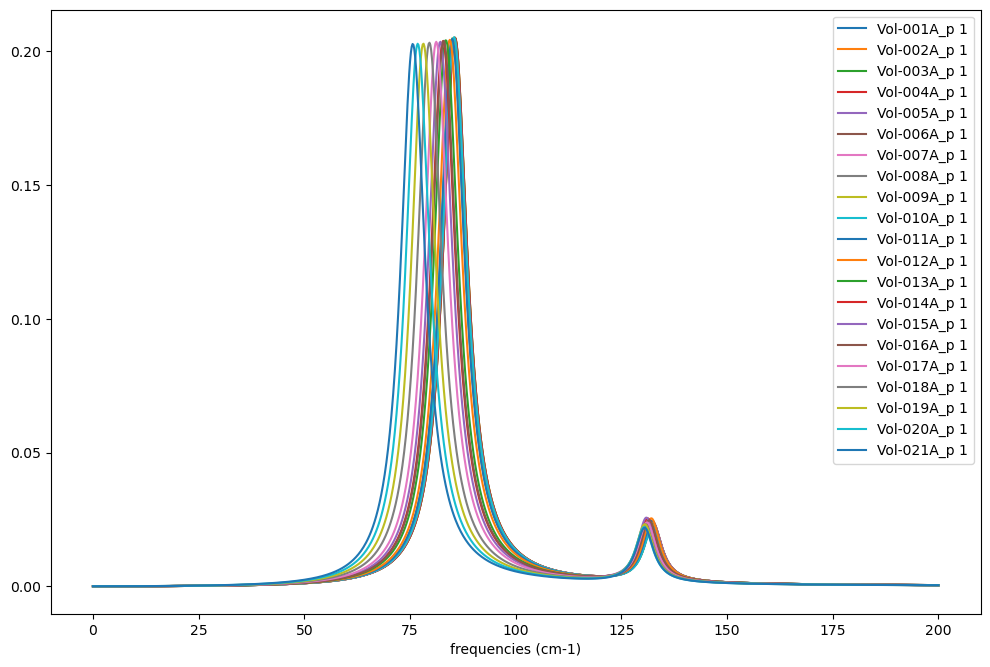

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


fig1 = plt.figure(); data[A_p].plot()





In [5]:
##useful snippets
#
#for x in crystal:
#    print(sheets[x])

In [6]:
import yaml
freq = pd.DataFrame()
Vollist = []
for files in qpointslist:
    with open(files) as f:
        data = yaml.load(f,Loader=yaml.FullLoader)
        df2 = pd.DataFrame(data['phonon'][0]['band'])
        m = re.search('Vol-(.+?)\\\\', files)
        vol = m.group(1)
        str1 = "Vol-" + vol
        Vollist.append(str1)
        df2 = df2.rename(columns={"frequency": str1})
        
        freq = pd.concat([freq,df2], axis=1)

In [7]:
Vol = pd.read_csv(e_v, sep="       ", engine='python')
Vol = Vol.set_axis(Vollist, axis='index')

display(Vol)


,# cell volume,energy of cell other than phonon
Vol-001,428.763528,-66.470257
Vol-002,428.763216,-66.470150
Vol-003,428.762590,-66.470215
Vol-004,428.800398,-66.470179
Vol-005,428.823834,-66.470274
Vol-006,428.863208,-66.470227
Vol-007,428.902584,-66.470300
Vol-008,428.955401,-66.470317
Vol-009,429.008535,-66.470222
Vol-010,429.705631,-66.468913


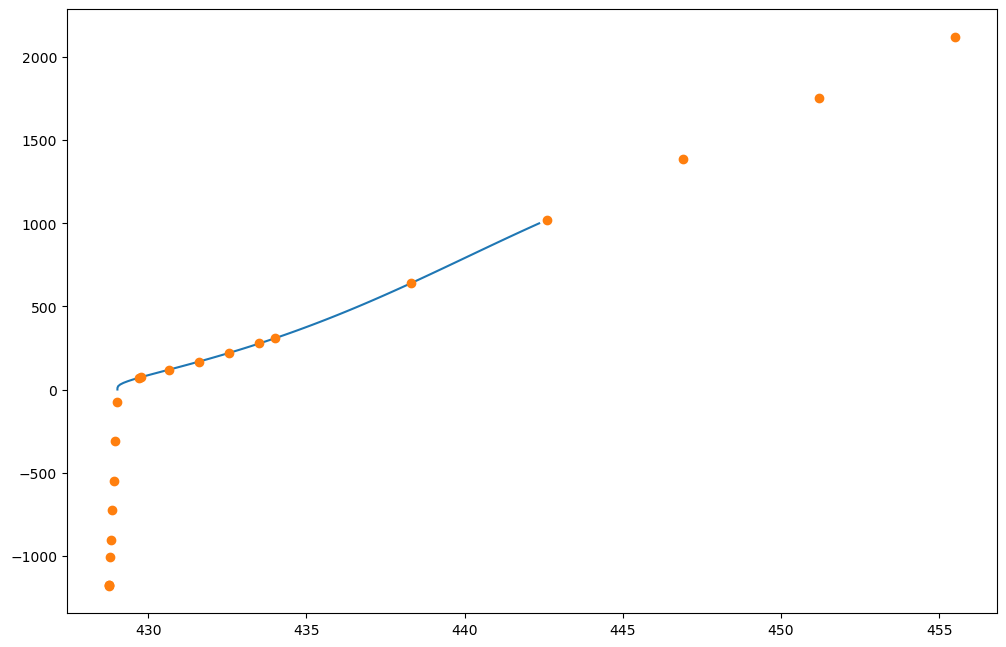

In [8]:
from scipy import odr
import numpy as np
from scipy import interpolate

Vt = pd.read_csv(v_t, sep="       ", engine='python', header=None)
Vt = Vt.set_axis(['Temperature', 'Volume'], axis=1)


f = interpolate.interp1d(Vt['Volume'], Vt['Temperature'], fill_value="extrapolate")
ynew = f(Vol['#   cell volume'].iloc[0:])

#temp = np.insert(ynew, 0, 0.0000)

Vol['Temperature'] = ynew
Vol['Freq'] = freq.iloc[19]

plt.plot(Vt['Volume'], Vt['Temperature'], '-', Vol['#   cell volume'].iloc[0:], ynew, 'o')

plt.show()



In [9]:

f = interpolate.interp1d(Vt['Temperature'], Vt['Volume'], fill_value="extrapolate")

newTemps = [1, 5, 10, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250, 300]

Volumes = f(newTemps)

display(Volumes)

# temp = np.insert(ynew, 0, 0.0000)

# Vol['Temperature'] = temp

# plt.plot(Vt['Volume'], Vt['Temperature'], '-', Vol['#   cell volume'].iloc[1:], ynew, 'o')

# plt.show()


array([429.02481457, 429.02570164, 429.02681047, 429.08043577,
       429.11210501, 429.164258  , 429.21641098, 429.28502849,
       429.353646  , 430.26989591, 431.25819876, 432.19558089,
       433.06566682, 433.87294135])

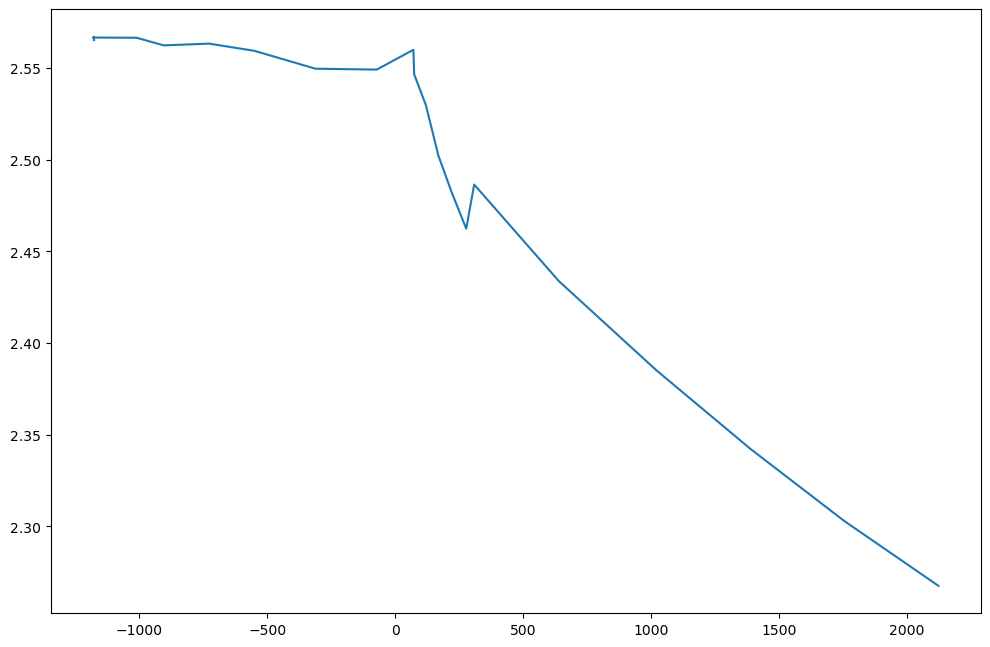

In [10]:
plt.plot(Vol['Temperature'], Vol['Freq'])
plt.show()

In [18]:

root = 'C:\\QHA\\new\\QHA2\\finer_new'
qpointslist = [val for sublist in [[os.path.join(i[0], j) for j in i[2] if j.endswith('qpoints.yaml')] for i in os.walk(root)] for val in sublist]


freq2 = pd.DataFrame()
Vollist = []
for files in qpointslist:
    with open(files) as f:
        data = yaml.load(f,Loader=yaml.FullLoader)
        df2 = pd.DataFrame(data['phonon'][0]['band'])
        m = re.search('Vol-(.+?)\\\\', files)
        vol = m.group(1)
        str1 = "Vol-" + vol
        Vollist.append(str1)
        df2 = df2.rename(columns={"frequency": str1})
        
        freq2 = pd.concat([freq2,df2], axis=1)

In [38]:
Vol2 = pd.DataFrame()
Vol2 = Vol2.set_axis(Vollist, axis='index')
Vol2['Temperature'] = newTemps
Vol2['Freq'] = freq2.iloc[19]

display(Vol2['Freq'])

Vol-001    2.561598
Vol-002    2.553724
Vol-003    2.557726
Vol-004    2.552862
Vol-005    2.559003
Vol-006    2.558020
Vol-007    2.541452
Vol-008    2.557446
Vol-009    2.553927
Vol-010    2.539324
Vol-011    2.518553
Vol-012    2.491626
Vol-013    2.473594
Vol-014    2.452954
Name: Freq, dtype: float64

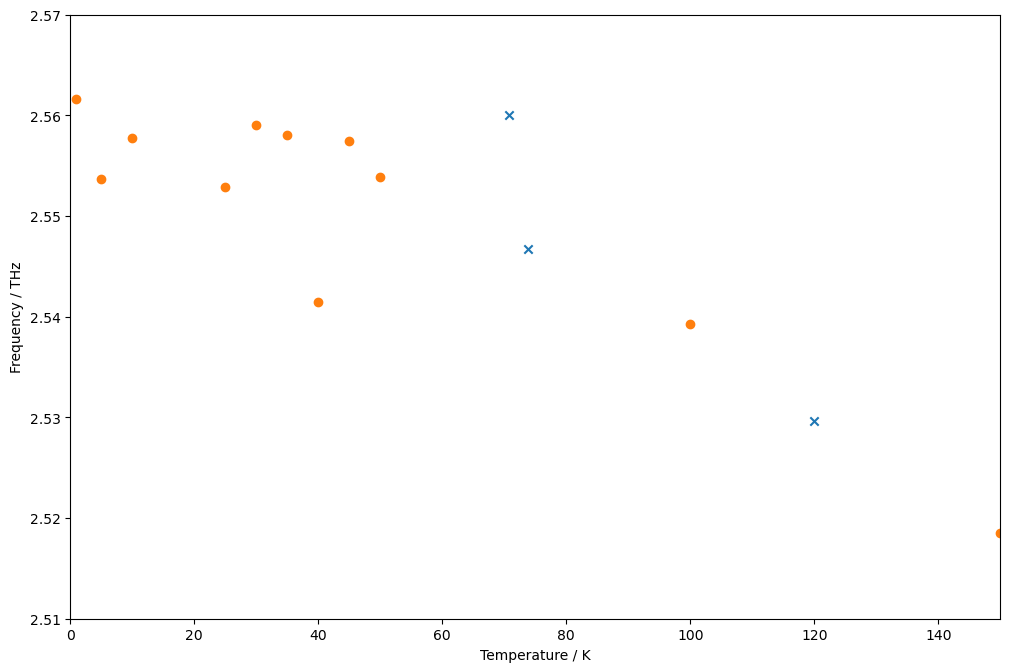

In [53]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(Vol['Temperature'], Vol['Freq'], marker ="x")
ax1.scatter(Vol2['Temperature'], Vol2['Freq'], marker ="o")
plt.xlim([0,150])
plt.ylim([2.51,2.57])
plt.xlabel("Temperature / K")
plt.ylabel("Frequency / THz")
plt.savefig('temp.pdf', bbox_inches='tight', transparent='True')
plt.show()

